In [ ]:
! pip install -q kaggle
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download 'masoudnickparvar/brain-tumor-mri-dataset' --unzip --force

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn as nn
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
img_height, img_width = 299, 299
input_shape=torch.Tensor((img_height, img_width))
train_data_dir = '/content/Training'
validation_data_dir = '/content/Testing'

classes = ('glioma','meningioma','notumour','pituitary')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

In [ ]:
# Resize the image and do a center crop, and store them on a tensor
transform = transforms.Compose([transforms.Resize(img_height),transforms.CenterCrop(img_width), transforms.ToTensor()])

# Load the training and validation dataset
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
val_dataset = datasets.ImageFolder(validation_data_dir, transform=transform)

In [ ]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,num_workers=2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


This is a pituitary.


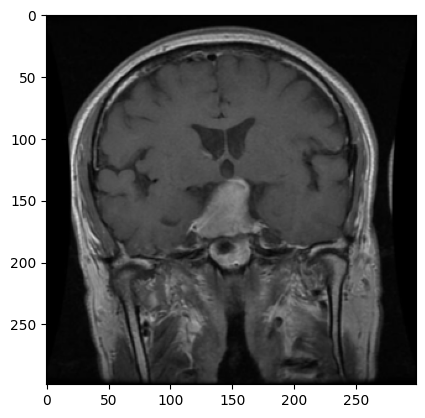

In [ ]:
images,labels = next(iter(train_dataloader))
print('This is a {}.'.format(classes[labels[0]]))
plt.imshow(images[0].moveaxis(0,2))

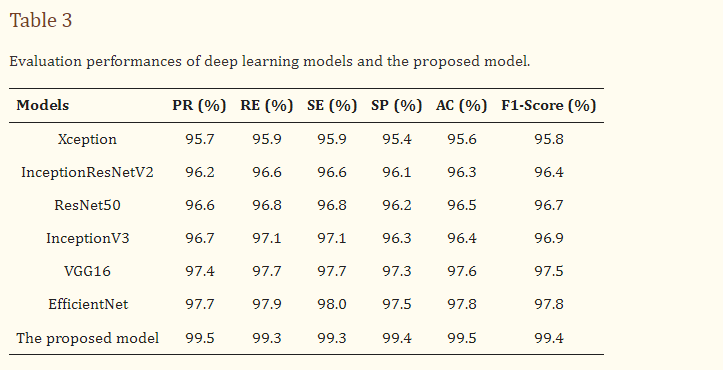

In [ ]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10453020/
# DenseNet [39]	94.6	94.7	94.7	94.2	94.4	94.6
# VGG19 [38]	95.3	95.4	95.4	95.0	94.9	95.2
# CNN Ensemble [42]	95.7	95.6	95.6	95.1	95.3	95.5
# Hybrid Ensemble [41]	95.6	96.0	96.0	95.3	95.2	95.7
# SVM [36]	96.3	96.5	96.5	96.2	96.5	96.3
# EfficientNet [79]	97.5	97.6	97.6	97.4	97.6	97.6
# YOLOv4 [80]	97.6	97.8	97.8	97.5	97.5	97.8
# The proposed model	99.5	99.3	99.3	99.4	99.5	99.4


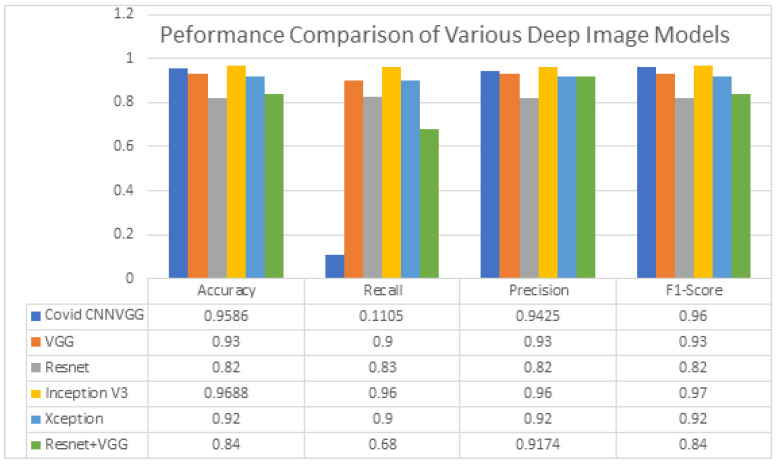

In [ ]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9687278/
#better performing models
# so we used some transfer learning to understand how it works on our dataset

RESNET 50

In [ ]:
import torchvision.models as models

base_model = models.resnet50(pretrained=True)


base_model.fc = nn.Identity()


for param in base_model.parameters():
    param.requires_grad = False


classifier = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(128, 4),
    nn.Softmax(dim=1)
)

model = nn.Sequential(
    base_model,
    classifier
)

print(model)

sample_input = torch.randn(1, 3, 299, 299)

print("Sample input shape:", sample_input.shape)

output = model(sample_input)
print("Output shape:", output.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

DENSENET 121


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models


base_model = models.densenet121(pretrained=True)


base_model.classifier = nn.Identity()


for param in base_model.parameters():
    param.requires_grad = False


classifier = nn.Sequential(
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(128, 4),
    nn.Softmax(dim=1)
)


model = nn.Sequential(
    base_model,
    classifier
)

print(model)
sample_input = torch.randn(1, 3, 299, 299)


print("Sample input shape:", sample_input.shape)

output = model(sample_input)
print("Output shape:", output.shape)


LOAD THE MODELS AND RUN THIS CODE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 20


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []
val_precision_scores = []
val_recall_scores = []

best_val_accuracy = 0.0
best_confusion_matrix = None


for epoch in range(epochs):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()


        outputs = model(inputs)
        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)


        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)


    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predicted_list = []
    val_labels_list = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_predicted_list.extend(predicted.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    val_epoch_loss = val_running_loss / len(val_dataloader.dataset)
    val_accuracy = 100 * val_correct / val_total
    val_f1 = f1_score(val_labels_list, val_predicted_list, average='weighted')
    val_precision = precision_score(val_labels_list, val_predicted_list, average='weighted')
    val_recall = recall_score(val_labels_list, val_predicted_list, average='weighted')

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation F1 Score: {val_f1:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")


    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_confusion_matrix = confusion_matrix(val_labels_list, val_predicted_list)
        print("Confusion Matrix:")
        print(best_confusion_matrix)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

base_model = models.resnet50(pretrained=True)

base_model.fc = nn.Identity()

for param in base_model.parameters():
    param.requires_grad = False


classifier = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(128, 4),
    nn.Softmax(dim=1)
)


model = nn.Sequential(
    base_model,
    classifier
)

print(model)

sample_input = torch.randn(1, 3, 224, 224)
print("Sample input shape:", sample_input.shape)

output = model(sample_input)
print("Output shape:", output.shape)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/20, Loss: 1.0265, Validation Loss: 0.9446, Validation Accuracy: 80.02%, Validation F1 Score: 0.7944, Validation Precision: 0.7960, Validation Recall: 0.8002
Confusion Matrix:
[[231  69   0   0]
 [ 33 161  97  15]
 [  5   5 392   3]
 [  9  26   0 265]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/20, Loss: 0.9143, Validation Loss: 0.9316, Validation Accuracy: 81.16%, Validation F1 Score: 0.8067, Validation Precision: 0.8156, Validation Recall: 0.8116
Confusion Matrix:
[[211  87   0   2]
 [  5 178  93  30]
 [  3   4 391   7]
 [  3  13   0 284]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/20, Loss: 0.9019, Validation Loss: 0.9247, Validation Accuracy: 81.62%, Validation F1 Score: 0.8117, Validation Precision: 0.8182, Validation Recall: 0.8162
Confusion Matrix:
[[218  82   0   0]
 [ 14 176  97  19]
 [  3   4 396   2]
 [  2  18   0 280]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/20, Loss: 0.8890, Validation Loss: 0.9311, Validation Accuracy: 81.01%, Validation F1 Score: 0.8055, Validation Precision: 0.8239, Validation Recall: 0.8101


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/20, Loss: 0.8882, Validation Loss: 0.9156, Validation Accuracy: 82.53%, Validation F1 Score: 0.8136, Validation Precision: 0.8178, Validation Recall: 0.8253
Confusion Matrix:
[[246  52   0   2]
 [ 31 151  93  31]
 [  4   3 392   6]
 [  4   3   0 293]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/20, Loss: 0.8843, Validation Loss: 0.9200, Validation Accuracy: 82.23%, Validation F1 Score: 0.8184, Validation Precision: 0.8225, Validation Recall: 0.8223


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/20, Loss: 0.8742, Validation Loss: 0.9204, Validation Accuracy: 82.38%, Validation F1 Score: 0.8181, Validation Precision: 0.8226, Validation Recall: 0.8238


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/20, Loss: 0.8786, Validation Loss: 0.9286, Validation Accuracy: 81.31%, Validation F1 Score: 0.8113, Validation Precision: 0.8280, Validation Recall: 0.8131


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/20, Loss: 0.8693, Validation Loss: 0.9107, Validation Accuracy: 82.99%, Validation F1 Score: 0.8206, Validation Precision: 0.8235, Validation Recall: 0.8299
Confusion Matrix:
[[243  56   0   1]
 [ 25 161  91  29]
 [  5   3 392   5]
 [  2   6   0 292]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/20, Loss: 0.8860, Validation Loss: 0.9284, Validation Accuracy: 80.78%, Validation F1 Score: 0.8090, Validation Precision: 0.8244, Validation Recall: 0.8078


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/20, Loss: 0.8741, Validation Loss: 0.9235, Validation Accuracy: 81.77%, Validation F1 Score: 0.7973, Validation Precision: 0.8136, Validation Recall: 0.8177


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/20, Loss: 0.8659, Validation Loss: 0.9035, Validation Accuracy: 83.83%, Validation F1 Score: 0.8373, Validation Precision: 0.8471, Validation Recall: 0.8383
Confusion Matrix:
[[218  81   0   1]
 [  3 210  78  15]
 [  3   6 394   2]
 [  3  20   0 277]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/20, Loss: 0.8746, Validation Loss: 0.9042, Validation Accuracy: 83.75%, Validation F1 Score: 0.8304, Validation Precision: 0.8387, Validation Recall: 0.8375


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/20, Loss: 0.8652, Validation Loss: 0.9110, Validation Accuracy: 82.91%, Validation F1 Score: 0.8237, Validation Precision: 0.8374, Validation Recall: 0.8291


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/20, Loss: 0.8696, Validation Loss: 0.9385, Validation Accuracy: 80.17%, Validation F1 Score: 0.7925, Validation Precision: 0.8123, Validation Recall: 0.8017


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 16/20, Loss: 0.8637, Validation Loss: 0.9025, Validation Accuracy: 83.75%, Validation F1 Score: 0.8306, Validation Precision: 0.8328, Validation Recall: 0.8375


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 17/20, Loss: 0.8616, Validation Loss: 0.8988, Validation Accuracy: 84.21%, Validation F1 Score: 0.8394, Validation Precision: 0.8450, Validation Recall: 0.8421
Confusion Matrix:
[[229  68   0   3]
 [  6 200  77  23]
 [  3   5 393   4]
 [  2  16   0 282]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18/20, Loss: 0.8637, Validation Loss: 0.9041, Validation Accuracy: 83.75%, Validation F1 Score: 0.8319, Validation Precision: 0.8396, Validation Recall: 0.8375


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 19/20, Loss: 0.8600, Validation Loss: 0.9117, Validation Accuracy: 82.84%, Validation F1 Score: 0.8315, Validation Precision: 0.8488, Validation Recall: 0.8284


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 20/20, Loss: 0.8724, Validation Loss: 0.8866, Validation Accuracy: 85.35%, Validation F1 Score: 0.8516, Validation Precision: 0.8570, Validation Recall: 0.8535
Confusion Matrix:
[[225  74   0   1]
 [  6 215  51  34]
 [  3   8 390   4]
 [  2   9   0 289]]


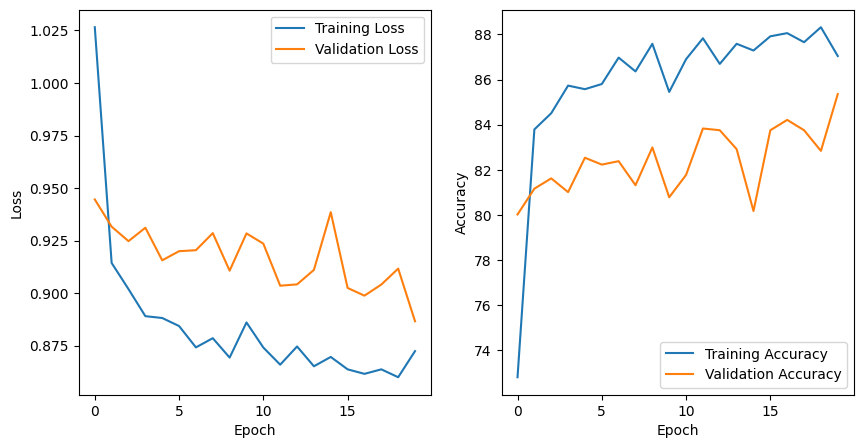

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []
val_precision_scores = []
val_recall_scores = []

best_val_accuracy = 0.0
best_confusion_matrix = None

for epoch in range(epochs):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()


        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predicted_list = []
    val_labels_list = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_predicted_list.extend(predicted.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    val_epoch_loss = val_running_loss / len(val_dataloader.dataset)
    val_accuracy = 100 * val_correct / val_total
    val_f1 = f1_score(val_labels_list, val_predicted_list, average='weighted')
    val_precision = precision_score(val_labels_list, val_predicted_list, average='weighted')
    val_recall = recall_score(val_labels_list, val_predicted_list, average='weighted')

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation F1 Score: {val_f1:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_confusion_matrix = confusion_matrix(val_labels_list, val_predicted_list)
        print("Confusion Matrix:")
        print(best_confusion_matrix)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

base_model = models.xception(pretrained=True)

base_model.fc = nn.Identity()

for param in base_model.parameters():
    param.requires_grad = False


classifier = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(128, 4),
    nn.Softmax(dim=1)
)


model = nn.Sequential(
    base_model,
    classifier
)


print(model)

sample_input = torch.randn(1, 3, 299, 299)

print("Sample input shape:", sample_input.shape)
output = model(sample_input)
print("Output shape:", output.shape)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models


base_model = models.vgg16(pretrained=True)


base_model.classifier[6] = nn.Identity()


for param in base_model.parameters():
    param.requires_grad = False


classifier = nn.Sequential(
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 4),
    nn.Softmax(dim=1)
)

# Combine base model and classifier
model = nn.Sequential(
    base_model,
    classifier
)

# Print the model
print(model)

# Sample input shape
sample_input = torch.randn(1, 3, 224, 224)  # VGG expects input size of 224x224

# Print the input shape
print("Sample input shape:", sample_input.shape)

# Pass the sample input through the model and print shapes after each layer
output = model(sample_input)
print("Output shape:", output.shape)

Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

In [ ]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

img_height, img_width = 224, 224

train_data_dir = '/content/Training'
validation_data_dir = '/content/Testing'

classes = ('glioma', 'meningioma', 'notumour', 'pituitary')


transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.CenterCrop((img_height, img_width)),
    transforms.ToTensor()
])

# Load the training and validation dataset
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
val_dataset = datasets.ImageFolder(validation_data_dir, transform=transform)

batch_size = 32
train_dataloader1 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader1 = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)


Epoch 1/20, Loss: 1.0771, Validation Loss: 0.9988, Validation Accuracy: 74.07%, Validation F1 Score: 0.7029, Validation Precision: 0.7511, Validation Recall: 0.7407
Confusion Matrix:
[[269  18   5   8]
 [122  63  57  64]
 [ 24   1 376   4]
 [ 28   3   6 263]]
Epoch 2/20, Loss: 0.9929, Validation Loss: 0.9589, Validation Accuracy: 77.65%, Validation F1 Score: 0.7652, Validation Precision: 0.7677, Validation Recall: 0.7765
Confusion Matrix:
[[236  53   3   8]
 [ 52 138  54  62]
 [ 16   5 373  11]
 [ 17   9   3 271]]
Epoch 3/20, Loss: 0.9594, Validation Loss: 0.9573, Validation Accuracy: 78.72%, Validation F1 Score: 0.7766, Validation Precision: 0.7833, Validation Recall: 0.7872
Confusion Matrix:
[[219  66   2  13]
 [ 26 144  47  89]
 [  5  10 381   9]
 [  9   0   3 288]]
Epoch 4/20, Loss: 0.9559, Validation Loss: 0.9660, Validation Accuracy: 77.80%, Validation F1 Score: 0.7845, Validation Precision: 0.8058, Validation Recall: 0.7780
Epoch 5/20, Loss: 0.9492, Validation Loss: 0.9363, Vali

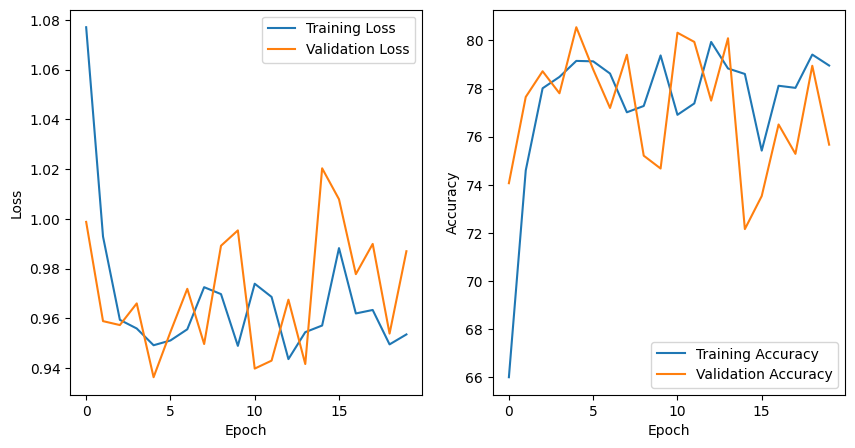

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []
val_precision_scores = []
val_recall_scores = []

best_val_accuracy = 0.0
best_confusion_matrix = None

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_dataloader1:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataloader1.dataset)
    train_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predicted_list = []
    val_labels_list = []
    with torch.no_grad():
        for inputs, labels in val_dataloader1:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_predicted_list.extend(predicted.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    val_epoch_loss = val_running_loss / len(val_dataloader1.dataset)
    val_accuracy = 100 * val_correct / val_total
    val_f1 = f1_score(val_labels_list, val_predicted_list, average='weighted')
    val_precision = precision_score(val_labels_list, val_predicted_list, average='weighted')
    val_recall = recall_score(val_labels_list, val_predicted_list, average='weighted')

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation F1 Score: {val_f1:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_confusion_matrix = confusion_matrix(val_labels_list, val_predicted_list)
        print("Confusion Matrix:")
        print(best_confusion_matrix)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

STOP

wif dilation

In [ ]:
#wif dilation:
import torch
import torch.nn as nn

class NaiveCNN(nn.Module):
    def __init__(self, num_classes):
        super(NaiveCNN, self).__init__()


        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, dilation=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, dilation=2)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, dilation=2)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, dilation=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self._calculate_linear_input_size()


        self.fc1 = nn.Linear(self.linear_input_size, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, num_classes)


        self.relu = nn.ReLU()

    def _calculate_linear_input_size(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 299, 299)
            x = self.conv1(x)
            x = self.pool(x)
            x = self.conv2(x)
            x = self.pool(x)
            x = self.conv3(x)
            x = self.pool(x)
            x = self.conv4(x)
            x = self.pool(x)
            x = self.conv5(x)
            x = self.pool(x)
            self.linear_input_size = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Convolutional layers with relu activation and max pooling
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.relu(self.conv5(x))
        x = self.pool(x)

        # Flatten
        x = torch.flatten(x, 1)

        # Fully connected layers with relu activation
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        # Output layer with softmax activation for classification
        x = self.fc3(x)

        return x


model = NaiveCNN(num_classes=4)  # Change num_classes based on your dataset

sample_input = torch.randn(1, 3, 299, 299)  # Adjust input size as needed

# Forward pass
output = model(sample_input)

print("Output shape:", output.shape)


Output shape: torch.Size([1, 4])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/20, Loss: 0.8978, Validation Loss: 0.6981, Validation Accuracy: 71.70%, Validation F1 Score: 0.6699, Validation Precision: 0.6892, Validation Recall: 0.7170
Confusion Matrix:
[[268  15   0  17]
 [136  44  96  30]
 [ 15  17 347  26]
 [ 10   7   2 281]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/20, Loss: 0.4826, Validation Loss: 0.4855, Validation Accuracy: 81.31%, Validation F1 Score: 0.8131, Validation Precision: 0.8315, Validation Recall: 0.8131
Confusion Matrix:
[[177 112   2   9]
 [ 20 235  39  12]
 [  3  16 385   1]
 [  1  29   1 269]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/20, Loss: 0.3527, Validation Loss: 0.4730, Validation Accuracy: 79.86%, Validation F1 Score: 0.7793, Validation Precision: 0.8262, Validation Recall: 0.7986


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/20, Loss: 0.2530, Validation Loss: 0.2488, Validation Accuracy: 91.00%, Validation F1 Score: 0.9084, Validation Precision: 0.9084, Validation Recall: 0.9100
Confusion Matrix:
[[262  34   0   4]
 [ 32 238  29   7]
 [  2   2 401   0]
 [  2   3   3 292]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/20, Loss: 0.1842, Validation Loss: 0.2805, Validation Accuracy: 90.08%, Validation F1 Score: 0.9001, Validation Precision: 0.9074, Validation Recall: 0.9008


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/20, Loss: 0.1515, Validation Loss: 0.2342, Validation Accuracy: 91.69%, Validation F1 Score: 0.9163, Validation Precision: 0.9216, Validation Recall: 0.9169
Confusion Matrix:
[[230  65   1   4]
 [ 12 279  10   5]
 [  3   5 396   1]
 [  0   2   1 297]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/20, Loss: 0.1183, Validation Loss: 0.7092, Validation Accuracy: 88.56%, Validation F1 Score: 0.8807, Validation Precision: 0.8920, Validation Recall: 0.8856


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/20, Loss: 0.0999, Validation Loss: 0.3726, Validation Accuracy: 88.86%, Validation F1 Score: 0.8892, Validation Precision: 0.8933, Validation Recall: 0.8886


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/20, Loss: 0.0963, Validation Loss: 0.1362, Validation Accuracy: 95.65%, Validation F1 Score: 0.9565, Validation Precision: 0.9570, Validation Recall: 0.9565
Confusion Matrix:
[[277  19   0   4]
 [ 13 285   2   6]
 [  1   6 393   5]
 [  0   1   0 299]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/20, Loss: 0.0545, Validation Loss: 0.1449, Validation Accuracy: 96.19%, Validation F1 Score: 0.9616, Validation Precision: 0.9632, Validation Recall: 0.9619
Confusion Matrix:
[[264  32   1   3]
 [  4 293   7   2]
 [  0   0 405   0]
 [  0   1   0 299]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/20, Loss: 0.0500, Validation Loss: 0.1294, Validation Accuracy: 96.41%, Validation F1 Score: 0.9641, Validation Precision: 0.9644, Validation Recall: 0.9641
Confusion Matrix:
[[276  20   1   3]
 [  8 289   4   5]
 [  0   2 403   0]
 [  1   3   0 296]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/20, Loss: 0.0454, Validation Loss: 0.1398, Validation Accuracy: 96.26%, Validation F1 Score: 0.9625, Validation Precision: 0.9624, Validation Recall: 0.9626


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/20, Loss: 0.0408, Validation Loss: 0.2527, Validation Accuracy: 95.42%, Validation F1 Score: 0.9540, Validation Precision: 0.9565, Validation Recall: 0.9542


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/20, Loss: 0.0569, Validation Loss: 0.4926, Validation Accuracy: 91.00%, Validation F1 Score: 0.9081, Validation Precision: 0.9221, Validation Recall: 0.9100


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/20, Loss: 0.0782, Validation Loss: 0.1224, Validation Accuracy: 96.64%, Validation F1 Score: 0.9662, Validation Precision: 0.9667, Validation Recall: 0.9664
Confusion Matrix:
[[274  23   0   3]
 [  7 289   7   3]
 [  0   0 405   0]
 [  0   1   0 299]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 16/20, Loss: 0.0245, Validation Loss: 0.2003, Validation Accuracy: 95.35%, Validation F1 Score: 0.9530, Validation Precision: 0.9535, Validation Recall: 0.9535


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 17/20, Loss: 0.0397, Validation Loss: 0.2396, Validation Accuracy: 95.35%, Validation F1 Score: 0.9528, Validation Precision: 0.9535, Validation Recall: 0.9535


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18/20, Loss: 0.0271, Validation Loss: 0.1127, Validation Accuracy: 97.33%, Validation F1 Score: 0.9732, Validation Precision: 0.9733, Validation Recall: 0.9733
Confusion Matrix:
[[282  16   0   2]
 [  9 292   2   3]
 [  2   0 402   1]
 [  0   0   0 300]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 19/20, Loss: 0.0272, Validation Loss: 0.2951, Validation Accuracy: 94.43%, Validation F1 Score: 0.9439, Validation Precision: 0.9456, Validation Recall: 0.9443


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 20/20, Loss: 0.0301, Validation Loss: 0.1693, Validation Accuracy: 97.18%, Validation F1 Score: 0.9716, Validation Precision: 0.9717, Validation Recall: 0.9718


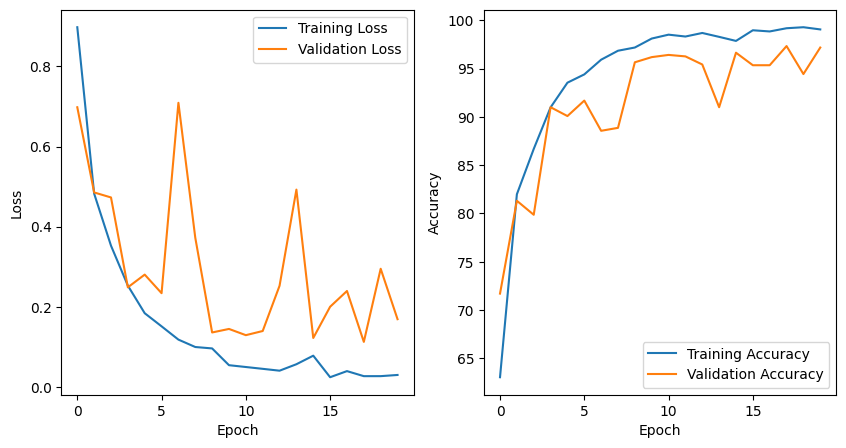

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []
val_precision_scores = []
val_recall_scores = []

best_val_accuracy = 0.0
best_confusion_matrix = None


for epoch in range(epochs):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()


        outputs = model(inputs)
        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)


        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)


    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predicted_list = []
    val_labels_list = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_predicted_list.extend(predicted.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    val_epoch_loss = val_running_loss / len(val_dataloader.dataset)
    val_accuracy = 100 * val_correct / val_total
    val_f1 = f1_score(val_labels_list, val_predicted_list, average='weighted')
    val_precision = precision_score(val_labels_list, val_predicted_list, average='weighted')
    val_recall = recall_score(val_labels_list, val_predicted_list, average='weighted')

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation F1 Score: {val_f1:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")


    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_confusion_matrix = confusion_matrix(val_labels_list, val_predicted_list)
        print("Confusion Matrix:")
        print(best_confusion_matrix)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

XCEPTION AND RESNET IMPLEMENTATION MODEL


In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary  # Import summary from torchsummary

class MyModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(MyModel, self).__init__()


        self.entry_flow = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Middle Flow (with residual blocks)
        self.middle_flow = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Residual block 1
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Residual block 2
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Exit Flow (inspired by Xception)
        self.exit_flow = nn.Sequential(
            nn.AvgPool2d(2, 2)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=87616, out_features=64),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = self.fc(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = MyModel(in_channels=3, num_classes=4).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()


summary(model, (3, img_height, img_width))

Run evaluation copy paste here after running model